In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from transformers import AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


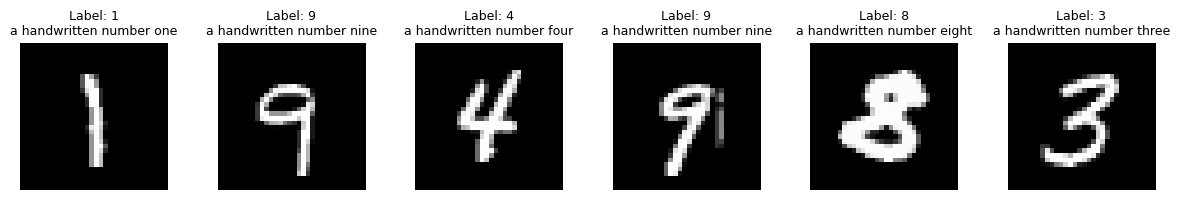

In [ ]:
# Map digit to descriptive text prompt
digit_to_text = {
    0: "a handwritten number zero",
    1: "a handwritten number one",
    2: "a handwritten number two",
    3: "a handwritten number three",
    4: "a handwritten number four",
    5: "a handwritten number five",
    6: "a handwritten number six",
    7: "a handwritten number seven",
    8: "a handwritten number eight",
    9: "a handwritten number nine"
}

class MNISTWithText(Dataset):
    def __init__(self, train=True):
        self.data = datasets.MNIST(
            root='./data',
            train=train,
            download=True,
            transform=transforms.Compose([
                transforms.Pad(2),
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x * 2. - 1.)  # to make the data between [-1, 1] for stable training
            ])
        )
        self.texts = [digit_to_text[int(label)] for label in self.data.targets]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        text = self.texts[idx]
        return img, text, label

train_dataset = MNISTWithText(train=True)
test_dataset = MNISTWithText(train=False)

# visualize some samples from the training set
import matplotlib.pyplot as plt
import numpy as np

n_samples = 6
indices = np.random.choice(len(train_dataset), n_samples, replace=False)
plt.figure(figsize=(12, 2))
for i, idx in enumerate(indices):
    img, text, label = train_dataset[idx]
    plt.subplot(1, n_samples, i+1)
    plt.imshow((img[0].numpy() + 1) / 2, cmap='gray')
    plt.title(f"Label: {label}\n{text}", fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# use a small BERT model for speed
bert_model_name = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert = AutoModel.from_pretrained(bert_model_name)
bert = bert.to(device)

# Freeze BERT weights for speed/memory
for param in bert.parameters():
    param.requires_grad = False

def get_text_embedding(texts, device):
    tokens = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=16)
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)
    with torch.no_grad():
        outputs = bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings

In [ ]:
def get_timestep_embedding(timesteps, embedding_dim):
    """
    Create sinusoidal timestep embeddings.
    timesteps: (batch,) or (1,)
    Returns: (batch, embedding_dim)
    """
    half_dim = embedding_dim // 2
    exponent = torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) / half_dim
    exponent = 10000 ** (-exponent)
    emb = timesteps[:, None].float() * exponent[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = F.pad(emb, (0, 1))
    return emb

In [ ]:
class SelfAttention2d(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.proj = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        x_norm = self.norm(x)
        q = self.q(x_norm).reshape(B, C, H*W).permute(0, 2, 1)  # (B, HW, C)
        k = self.k(x_norm).reshape(B, C, H*W)  # (B, C, HW)
        v = self.v(x_norm).reshape(B, C, H*W).permute(0, 2, 1)  # (B, HW, C)
        attn = torch.bmm(q, k) / (C ** 0.5)  # (B, HW, HW)
        attn = torch.softmax(attn, dim=-1)
        out = torch.bmm(attn, v).permute(0, 2, 1).reshape(B, C, H, W)
        out = self.proj(out)
        return x + out

class CrossAttention(nn.Module):
    def __init__(self, channels, context_dim):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Linear(context_dim, channels)
        self.v = nn.Linear(context_dim, channels)
        self.proj = nn.Conv2d(channels, channels, 1)

    def forward(self, x, context):
        # x: (B, C, H, W), context: (B, context_dim)
        B, C, H, W = x.shape
        x_norm = self.norm(x)
        q = self.q(x_norm).reshape(B, C, H*W).permute(0, 2, 1)  # (B, HW, C)
        k = self.k(context).unsqueeze(1)  # (B, 1, C)
        v = self.v(context).unsqueeze(1)  # (B, 1, C)
        attn = torch.bmm(q, k.transpose(1, 2)) / (C ** 0.5)  # (B, HW, 1)
        attn = torch.softmax(attn, dim=1)
        out = torch.bmm(attn, v).permute(0, 2, 1).reshape(B, C, H, W)
        out = self.proj(out)
        return x + out

In [ ]:
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim, context_dim, use_attn=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.emb_proj = nn.Linear(emb_dim, out_ch)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.use_attn = use_attn
        if use_attn:
            self.attn = SelfAttention2d(out_ch)
            self.cross_attn = CrossAttention(out_ch, context_dim)
        self.down = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

    def forward(self, x, t_emb, context):
        h = self.conv1(x)
        h = self.norm1(h)
        h = F.silu(h + self.emb_proj(t_emb)[:, :, None, None])
        h = self.conv2(h)
        h = self.norm2(h)
        if self.use_attn:
            h = self.attn(h)
            h = self.cross_attn(h, context)
        h_down = self.down(h)
        return h_down, h

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim, context_dim, use_attn=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.emb_proj = nn.Linear(emb_dim, out_ch)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.use_attn = use_attn
        if use_attn:
            self.attn = SelfAttention2d(out_ch)
            self.cross_attn = CrossAttention(out_ch, context_dim)
        self.up = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)

    def forward(self, x, skip, t_emb, context):
        # Center-crop skip to match x's spatial size
        def center_crop(tensor, target_height, target_width):
            _, _, h, w = tensor.shape
            start_h = (h - target_height) // 2
            start_w = (w - target_width) // 2
            return tensor[:, :, start_h:start_h+target_height, start_w:start_w+target_width]

        if x.shape[2:] != skip.shape[2:]:
            skip = center_crop(skip, x.shape[2], x.shape[3])
        h = torch.cat([x, skip], dim=1)
        h = self.conv1(h)
        h = self.norm1(h)
        h = F.silu(h + self.emb_proj(t_emb)[:, :, None, None])
        h = self.conv2(h)
        h = self.norm2(h)
        if self.use_attn:
            h = self.attn(h)
            h = self.cross_attn(h, context)
        h_up = self.up(h)
        return h_up

class UNet(nn.Module):
    def __init__(self, img_ch=1, base_ch=64, emb_dim=128, context_dim=128):
        super().__init__()
        self.init_conv = nn.Conv2d(img_ch, base_ch, 3, padding=1)
        self.down1 = DownBlock(base_ch, base_ch*2, emb_dim, context_dim, use_attn=False)
        self.down2 = DownBlock(base_ch*2, base_ch*4, emb_dim, context_dim, use_attn=True)
        self.down3 = DownBlock(base_ch*4, base_ch*8, emb_dim, context_dim, use_attn=True)
        self.bot1 = nn.Conv2d(base_ch*8, base_ch*8, 3, padding=1)
        self.bot2 = nn.Conv2d(base_ch*8, base_ch*8, 3, padding=1)
        self.up3 = UpBlock(base_ch*8+base_ch*8, base_ch*4, emb_dim, context_dim, use_attn=True)
        self.up2 = UpBlock(base_ch*4+base_ch*4, base_ch*2, emb_dim, context_dim, use_attn=True)
        self.up1 = UpBlock(base_ch*2+base_ch*2, base_ch, emb_dim, context_dim, use_attn=False)
        self.final_conv = nn.Conv2d(base_ch, img_ch, 1)

    def forward(self, x, t_emb, context):
        h0 = self.init_conv(x)
        h1_down, h1 = self.down1(h0, t_emb, context)
        h2_down, h2 = self.down2(h1_down, t_emb, context)
        h3_down, h3 = self.down3(h2_down, t_emb, context)
        h_bot = F.silu(self.bot1(h3_down))
        h_bot = F.silu(self.bot2(h_bot))
        h_up3 = self.up3(h_bot, h3, t_emb, context)
        h_up2 = self.up2(h_up3, h2, t_emb, context)
        h_up1 = self.up1(h_up2, h1, t_emb, context)
        out = self.final_conv(h_up1)
        return out